In [2]:
%cd /work/adapting-CLIP-VGPs/
import pandas as pd 

Flickr30K_BASE = '/work/adapting-CLIP-VGPs/data/flickr/'
test_dataset = pd.read_csv(f'{Flickr30K_BASE}phrases_data/phrase_pair_remove_trivial_match_test.csv')
test_dataset
train_dataset = pd.read_csv(f'{Flickr30K_BASE}phrases_data/phrase_pair_remove_trivial_match_train.csv')
train_dataset

/work/adapting-CLIP-VGPs


Unnamed: 0       image               phrase1                phrase2  \
0                 0  3359636318            two+people           group+people   
1                 1  3359636318            two+people                 stores   
2                 2  3359636318       video+game+shop           group+people   
3                 3  3359636318       video+game+shop                 stores   
4                 4  3359636318    mobile+phone+store           group+people   
...             ...         ...                   ...                    ...   
2383736     2383736  3286822339           many+people   side+crowded+walkway   
2383737     2383737  3286822339      busy+city+street  chinese+market+street   
2383738     2383738  3286822339           many+people  chinese+market+street   
2383739     2383739  3286822339                couple  chinese+market+street   
2383740     2383740  3286822339  side+crowded+walkway  chinese+market+street   

                      original_phrase1               original_phrase2  ytrue  
0                           Two people              A group of people  False  
1                           Two people                    some stores  False  
2                  the video game shop              A group of people  False  
3                  the video game shop                    some stores  False  
4               the mobile phone store              A group of people  False  
...                                ...                            ...    ...  
2383736                    many people  the side of a crowded walkway  False  
2383737             A busy city street          Chinese market street   True  
2383738                    many people          Chinese market street  False  
2383739                       A couple          Chinese market street  False  
2383740  the side of a crowded walkway          Chinese market street   True  

[2383741 rows x 7 columns]

# Posweight

In [3]:
pos_weight = len(train_dataset.ytrue)/sum(train_dataset.ytrue)
neg_weight = 1/(1-1/pos_weight)

In [4]:
pos_weight

7.566062648980978

In [5]:
neg_weight

1.152298272718308

In [6]:
(len(train_dataset.ytrue)-sum(train_dataset.ytrue))/sum(train_dataset.ytrue)

6.566062648980978

In [7]:
len(train_dataset.ytrue)/(len(train_dataset.ytrue)-sum(train_dataset.ytrue))

1.152298272718308

In [8]:
pos_weight/(pos_weight-1)

1.152298272718308

In [9]:
import torch

torch.as_tensor(neg_rate/pos_rate)

NameError: name 'neg_rate' is not defined

In [ ]:
demo_train = train_dataset[:100000]
len(demo_train)

100000

In [ ]:
demo_val = val_dataset[:len(demo_train)//28]
print(sum(demo_val.ytrue)/len(demo_val.ytrue))
print(len(demo_val))

0.14981797815737888
3571


In [ ]:
demo_test = test_dataset[:len(demo_train)//28]
print(sum(demo_test.ytrue)/len(demo_test.ytrue))

0.1341360963315598


In [ ]:
demo_train.to_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/demo_phrase_pair_remove_trivial_match_train.csv')
demo_test.to_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/demo_phrase_pair_remove_trivial_match_test.csv')
demo_val.to_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/demo_phrase_pair_remove_trivial_match_val.csv')

In [ ]:
val_dataset = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/phrase_pair_remove_trivial_match_val.csv')
test_dataset = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/phrase_pair_remove_trivial_match_test.csv')
print(sum(val_dataset.ytrue)/len(val_dataset.ytrue))
print(sum(test_dataset.ytrue)/len(test_dataset.ytrue))

0.1333077598901167
0.13286584240634802


In [ ]:
%cd /work/adapting-CLIP-VGPs
from torch.utils.data import DataLoader
from utils.heatmap_data import VGPsHeatmapsDataset

val_dataset = VGPsHeatmapsDataset(split='val')
val_loader = DataLoader(
    val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/work/adapting-CLIP-VGPs


In [ ]:
batch_iter = iter(val_loader)
batch = next(batch_iter)
image_paths = batch['img_idx']
left_text_ft = batch['left_text_emb']
right_text_ft = batch['right_text_emb']
left_heatmaps = batch['left_heatmap']
right_heatmaps = batch['right_heatmap']
labels = batch['label']

In [ ]:
labels.sum()

tensor(13)

# VGP examples

In [10]:
train_dataset[train_dataset.phrase1 == 'wooden+playhouse']

Unnamed: 0       image           phrase1 phrase2    original_phrase1  \
1204699     1204699  1000268201  wooden+playhouse    girl  a wooden playhouse   

        original_phrase2  ytrue  
1204699           A girl  False

In [3]:
from data.flickr.flickr30k_entities.flickr30k_entities_utils import *
# /work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/9726060.jpg
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/9726060.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['Young rock wall climbers brave the massive structure with precision and ease .',
 'Two children , one male and one female are practicing outdoor rock climbing .',
 'A boy and a girl climbing up a fake rock wall in climbing gear .',
 'Two young children are climbing an artificial rock face .',
 'Two children are climbing a rock wall .']

In [12]:
id_entitiey = load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/9726060.txt')
id_entitiey

{'284640': ['Young rock wall climbers',
  'Two children',
  'Two young children',
  'Two children'],
 '284644': ['the massive structure',
  'outdoor rock climbing',
  'a fake rock wall',
  'an artificial rock face',
  'a rock wall'],
 '284649': ['precision'],
 '284648': ['ease'],
 '284641': ['one male', 'A boy'],
 '284645': ['one female', 'a girl'],
 '284647': ['climbing gear']}

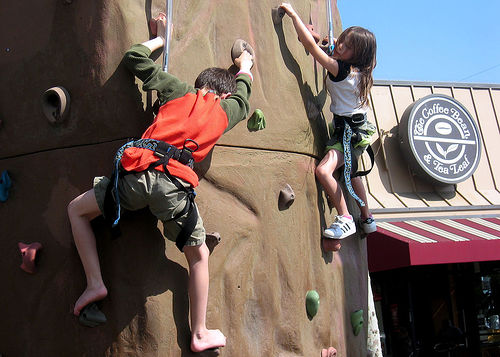

In [4]:
from PIL import Image
import numpy as np

def show_img(path):
    img = Image.open(path).convert("RGB")
    # img_data = np.array(img)
    img.show()
show_img(f'{Flickr30K_BASE}/flickr30k_images/9726060.jpg')

In [14]:
get_annotations('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_entities/Annotations/1000268201.xml')

{'boxes': {'18': [[7, 151, 107, 339]],
  '19': [[7, 190, 85, 298]],
  '20': [[0, 318, 114, 479]],
  '22': [[26, 7, 374, 387]],
  '23': [[37, 26, 108, 307]]},
 'scene': [],
 'nobox': ['21'],
 'width': 375,
 'height': 500,
 'depth': 3}

In [15]:
bbox_list = load_bbox(f'{Flickr30K_BASE}/flickr30k_entities/Annotations/1000268201.xml')
bbox_list

[((152, 8, 340, 108), ['18']),
 ((191, 8, 299, 86), ['19']),
 ((319, 1, 480, 115), ['20']),
 ((8, 27, 388, 375), ['22']),
 ((27, 38, 308, 109), ['23'])]

In [16]:
import matplotlib.pyplot as plt

im = Image.open(f'{Flickr30K_BASE}/flickr30k_images/1000268201.jpg').convert("RGB")
# im = np.array(im)
# plt.imshow(im)

In [17]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

im = Image.open(f'{Flickr30K_BASE}/flickr30k_images/1000268201.jpg').convert("RGB")
# Load the uploaded image
# Define the bounding boxes
boxes = {
    '18': [[7, 151, 107, 339]],
    '19': [[7, 190, 85, 298]],
    '20': [[0, 318, 114, 479]],
    '22': [[26, 7, 374, 387]],
    '23': [[37, 26, 108, 307]]
}

# Draw bounding boxes on the image
draw = ImageDraw.Draw(im)
for box_list in boxes.values():
    for box in box_list:
        # Each box is defined by the top left x,y and bottom right x,y
        top_left = (box[0], box[1])
        bottom_right = (box[2], box[3])
        draw.rectangle([top_left, bottom_right], outline="red", width=2)

# Display the image
plt.imshow(im)
plt.axis('off') # Hide the axes
plt.show()

# Find the image with the most VGP set

In [18]:
test_dataset

Unnamed: 0       image           phrase1         phrase2  \
0               0  1016887272  several+climbers  seven+climbers   
1               1  1016887272  several+climbers       rock+face   
2               2  1016887272  several+climbers     another+man   
3               3  1016887272  several+climbers            rope   
4               4  1016887272              rock  seven+climbers   
...           ...         ...               ...             ...   
81280       81280  1015118661               man          street   
81281       81281  1015118661               boy       young+boy   
81282       81282  1015118661               boy          street   
81283       81283  1015118661        stony+wall       young+boy   
81284       81284  1015118661        stony+wall          street   

       original_phrase1 original_phrase2  ytrue  
0      Several climbers   Seven climbers   True  
1      Several climbers      a rock face  False  
2      Several climbers      another man  False  
3      Several climbers         the rope  False  
4              the rock   Seven climbers  False  
...                 ...              ...    ...  
81280             a man       the street  False  
81281             A boy      A young boy   True  
81282             A boy       the street  False  
81283      a stony wall      A young boy  False  
81284      a stony wall       the street  False  

[81285 rows x 7 columns]

In [19]:
VGP_cnt = {}
from tqdm import tqdm

for img_idx in tqdm(test_dataset.image):
    id_entitiey = load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/1000268201.txt')
    cnt = 0
    for _, val in id_entitiey:
        cnt += 1 if len(id_entitiey)>1 else 0
    VGP_cnt[img_idx] = cnt

VGP_cnt

100%|██████████| 81285/81285 [00:16<00:00, 4874.40it/s]


{1016887272: 6,
 7162685234: 6,
 3000017878: 6,
 4971484184: 6,
 92679312: 6,
 2853682342: 6,
 5131842202: 6,
 4859170265: 6,
 2612125121: 6,
 3134644844: 6,
 316298162: 6,
 3601843201: 6,
 5086989679: 6,
 1246863003: 6,
 2193001254: 6,
 4283472819: 6,
 1117972841: 6,
 48614561: 6,
 6232601127: 6,
 4439654945: 6,
 269898428: 6,
 2113592981: 6,
 1542970158: 6,
 4743795506: 6,
 1313961775: 6,
 4005756399: 6,
 4844409798: 6,
 4970590451: 6,
 2536995789: 6,
 2230134548: 6,
 1295719054: 6,
 407815946: 6,
 4726677489: 6,
 2431723485: 6,
 4686568156: 6,
 688926797: 6,
 3245460937: 6,
 4759710534: 6,
 6338704: 6,
 2723024306: 6,
 23473996: 6,
 2831215155: 6,
 4682929932: 6,
 2736263351: 6,
 4376363559: 6,
 4937441878: 6,
 6386880789: 6,
 3698607223: 6,
 3134341610: 6,
 11551286: 6,
 214166720: 6,
 3179223972: 6,
 4540165999: 6,
 3217187564: 6,
 1097710887: 6,
 5138003138: 6,
 2743465453: 6,
 4650780114: 6,
 3518443604: 6,
 55438559: 6,
 3381788544: 6,
 3584603849: 6,
 2790909995: 6,
 777288299

In [20]:
min(VGP_cnt.values())

6

# BBox example

In [21]:
ex1 = train_dataset[ (train_dataset.original_phrase2 == 'A large brown dog')]
ex1

Unnamed: 0       image            phrase1          phrase2  \
51005         51005  3266306177          brown+dog  large+brown+dog   
51007         51007  3266306177  smaller+black+dog  large+brown+dog   
51023         51023  3266306177           two+dogs  large+brown+dog   
51025         51025  3266306177            smaller  large+brown+dog   
51027         51027  3266306177             larger  large+brown+dog   
...             ...         ...                ...              ...   
1798884     1798884  2276499757                dog  large+brown+dog   
1798887     1798887  2276499757          brown+dog  large+brown+dog   
1937653     1937653  3334057289              tiger  large+brown+dog   
1937656     1937656  3334057289                dog  large+brown+dog   
1937659     1937659  3334057289     weird+position  large+brown+dog   

            original_phrase1   original_phrase2  ytrue  
51005            A brown dog  A large brown dog   True  
51007    a smaller black dog  A large brown dog  False  
51023               Two dogs  A large brown dog  False  
51025        the smaller one  A large brown dog  False  
51027         the larger one  A large brown dog  False  
...                      ...                ...    ...  
1798884                A dog  A large brown dog   True  
1798887        the brown dog  A large brown dog   True  
1937653              A tiger  A large brown dog   True  
1937656                  dog  A large brown dog   True  
1937659     a weird position  A large brown dog  False  

[115 rows x 7 columns]

In [22]:
set(ex1.image)

{207275121,
 272546805,
 432248727,
 534313000,
 1341787777,
 1622619190,
 2094323311,
 2098418613,
 2276499757,
 2283966256,
 2552949275,
 2600867924,
 2855727603,
 2862469183,
 2874728371,
 3101796900,
 3266306177,
 3334057289,
 3515358125}

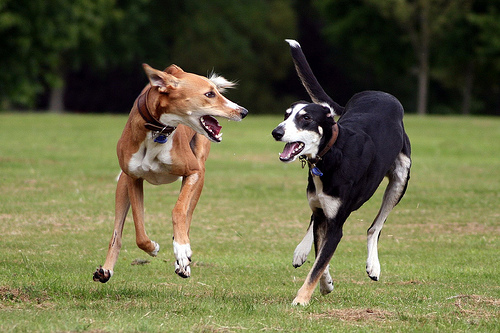

In [23]:
show_img(f'{Flickr30K_BASE}/flickr30k_images/2600867924.jpg')

In [24]:
get_annotations('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_entities/Annotations/2600867924.xml')

{'boxes': {'60728': [[269, 37, 413, 308]],
  '60729': [[269, 37, 413, 308], [87, 61, 252, 286]],
  '60735': [[87, 61, 252, 286]],
  '60731': [[0, 107, 499, 332]],
  '60732': [[266, 36, 417, 311]],
  '60734': [[94, 61, 246, 283]]},
 'scene': [],
 'nobox': ['60736'],
 'width': 500,
 'height': 333,
 'depth': 3}

In [25]:
load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/2600867924.txt')

{'60729': ['Two dogs', 'Two lean dogs', 'Two dogs', 'Two dogs'],
 '60736': ['bark outdoors'],
 '60734': ['one white and brown', 'one brown and white'],
 '60732': ['one white and black',
  'one brown and white',
  'one black and white',
  'one black and white'],
 '60731': ['a field', 'a grassy field'],
 '60735': ['A large brown dog'],
 '60728': ['a large black and white dog']}

# Failed iparaphrasing examples

In [26]:
test_dataset[ (test_dataset.phrase1 == 'street+window+shops')]

Unnamed: 0       image              phrase1  \
28993       28993  2254913901  street+window+shops   
28994       28994  2254913901  street+window+shops   
28995       28995  2254913901  street+window+shops   
28996       28996  2254913901  street+window+shops   
29003       29003  2254913901  street+window+shops   
29004       29004  2254913901  street+window+shops   
29005       29005  2254913901  street+window+shops   
29011       29011  2254913901  street+window+shops   
29012       29012  2254913901  street+window+shops   
29016       29016  2254913901  street+window+shops   

                          phrase2         original_phrase1  \
28993                       woman  the street window shops   
28994                       black  the street window shops   
28995                     outfits  the street window shops   
28996       clothing+store+window  the street window shops   
29003                       woman  the street window shops   
29004                     clothes  the street window shops   
29005  louis+vuitton+store+window  the street window shops   
29011                woman+window  the street window shops   
29012         louis+vuitton+store  the street window shops   
29016  louis+vuitton+store+window  the street window shops   

                   original_phrase2  ytrue  
28993                     The woman  False  
28994                         black  False  
28995                       outfits  False  
28996       a clothing store window  False  
29003                       A woman  False  
29004                       clothes  False  
29005  a Louis Vuitton store window  False  
29011                A woman window  False  
29012         a Louis Vuitton store  False  
29016  A Louis Vuitton store window  False

In [5]:
from data.flickr.flickr30k_entities.flickr30k_entities_utils import *
# /work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/9726060.jpg
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/2254913901.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['Woman on the street window shops in front of the store , Louis Vuitton .',
 'The woman in black is looking at outfits in a clothing store window .',
 'A woman looks at clothes in a Louis Vuitton store window .',
 'A woman window shops outside of a Louis Vuitton store .',
 'A Louis Vuitton store window at night .']

# Hard example

# Hard VGP

## 1 Both text and heatmap similarity didnt show good results

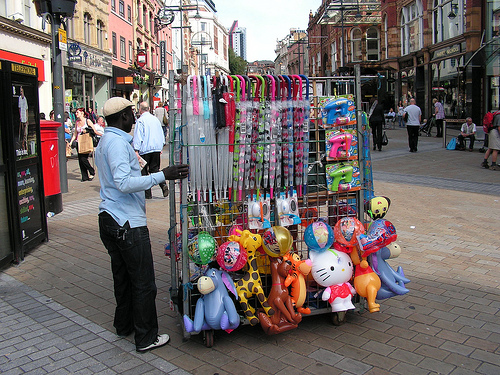

In [ ]:
from PIL import Image

Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/4005756399.jpg').show()

In [ ]:
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/4005756399.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['A vendor , selling such kid-friendly items as popular cartoon balloons , water guns and clear umbrellas , wheels his stand around in the streets where he is selling .',
 'A street vendor tends to his stand with lots of kids toys and items .',
 'A street vendor next to a stall of umbrellas and inflatable animals .',
 'A vendor sells souvenirs and trinkets on a busy street .',
 'Black man sells various toys in the street .']

In [ ]:
id_entitiey = load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/4005756399.txt')
id_entitiey

{'151675': ['A vendor',
  'A street vendor',
  'A street vendor',
  'A vendor',
  'Black man'],
 '151679': ['such kid-friendly items',
  'popular cartoon balloons',
  'lots of kids toys',
  'items',
  'souvenirs',
  'trinkets',
  'various toys'],
 '151681': ['water guns'],
 '151677': ['clear umbrellas', 'a stall of umbrellas'],
 '151678': ['his stand', 'his stand'],
 '151676': ['the streets', 'a busy street', 'the street'],
 '0': ['he'],
 '151682': ['inflatable animals']}

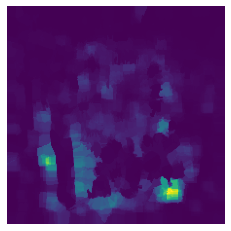

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def show_heatmap(img_idx, phrase):
    path = f'/work/adapting-CLIP-VGPs/data/flickr/heatmaps/test/{img_idx}/{phrase}.npz'
    def load_heatmaps(file_path):
        data = np.load(file_path, allow_pickle=True)
        heatmaps = [data[f'arr_{i}'] for i in range(len(data))]
        return heatmaps

    hm = load_heatmaps(path)
    plt.imshow(hm)
    plt.axis('off')

show_heatmap(4005756399, 'A street vendor')

In [8]:
path = '/work/adapting-CLIP-VGPs/data/flickr/heatmaps/test/4005756399/Black man.npz'
show_heatmap(4005756399, 'Black man')

# 2

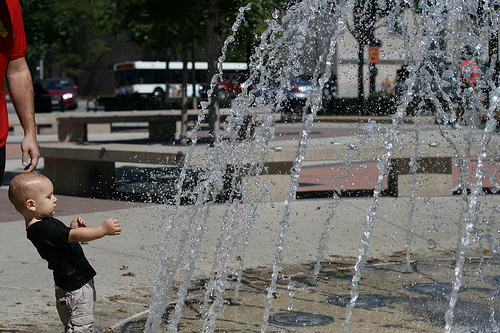

In [9]:
from PIL import Image

Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/2837804631.jpg').show()

In [10]:
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/2837804631.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['Very young boy is standing outside near a water fountain that is built into the ground and is squirting water .',
 'A little boy in a black shirt is leaning away from a water fountain .',
 'A little boy playing and getting wet from a park fountain .',
 'The little boy is about to walk into the sprinklers .',
 'A child being splashed by a water fountain .']

In [11]:
id_entitiey = load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/2837804631.txt')
id_entitiey

{'75953': ['Very young boy',
  'A little boy',
  'A little boy',
  'The little boy',
  'A child'],
 '75954': ['a water fountain',
  'water',
  'a water fountain',
  'a park fountain',
  'the sprinklers',
  'a water fountain'],
 '0': ['that', 'the ground'],
 '75956': ['a black shirt']}

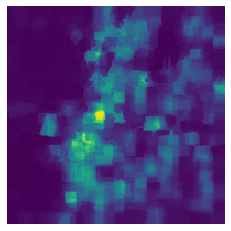

In [3]:
show_heatmap(2837804631, 'water')

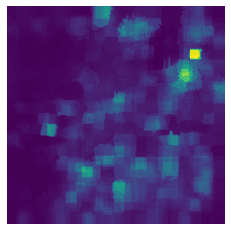

In [4]:
show_heatmap(2837804631,   'the sprinklers')

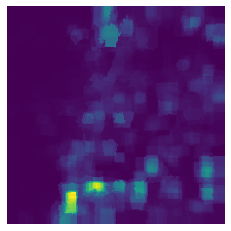

In [5]:
show_heatmap(2837804631, 'a park fountain')

In [6]:
23473996

23473996

# 3

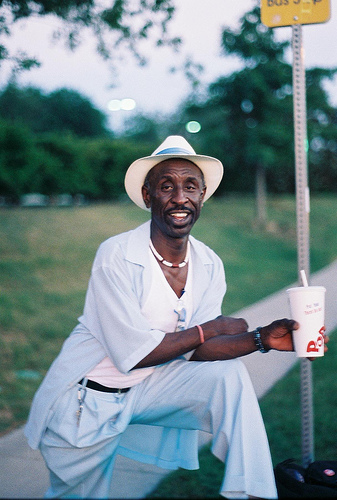

In [7]:
from PIL import Image

Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/2589156742.jpg').show()

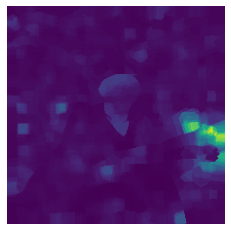

In [8]:
show_heatmap(2589156742 ,'a soft drink')

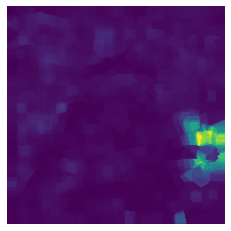

In [9]:
show_heatmap(2589156742 ,'a cup')

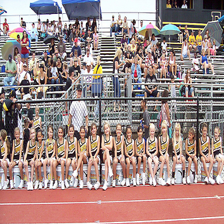

In [10]:
imID = 2822265828
Image.open(f'/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/{imID}.jpg').resize((224,224)).show()

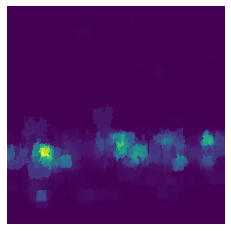

In [17]:
show_heatmap(imID, 'A row of young female cheerleaders')

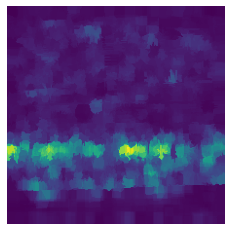

In [18]:
show_heatmap(imID, 'team')

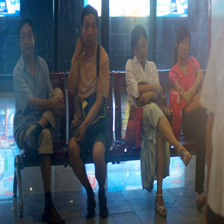

In [19]:
imID=4801764348
Image.open(f'/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/{imID}.jpg').resize((224,224)).show()

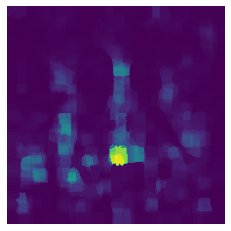

In [20]:
show_heatmap(imID, 'shiny , metallic , red chairs')

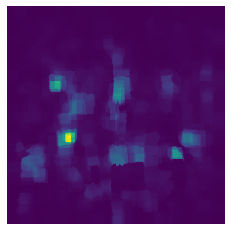

In [21]:
show_heatmap(imID, 'a bench')

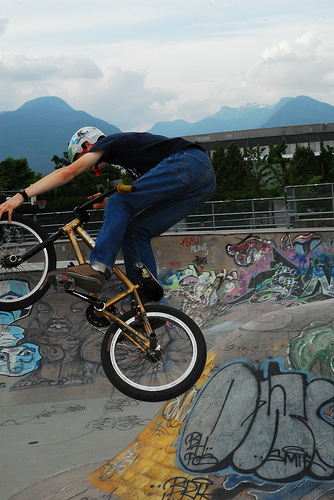

In [11]:
# 3634400263
Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/3634400263.jpg').show()

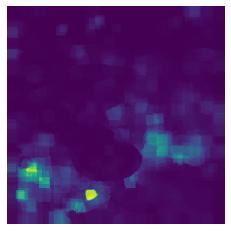

In [12]:
# 'a skate park', 'a graffitied concrete ramp'
show_heatmap(3634400263, 'a skate park')

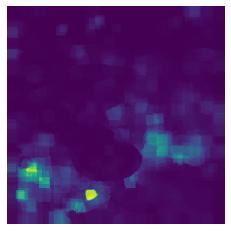

In [13]:
show_heatmap(3634400263, 'a skate park')

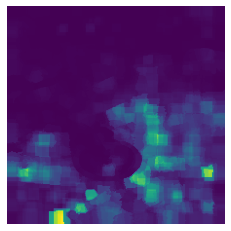

In [14]:
show_heatmap(3634400263 ,'a graffitied concrete ramp')

# 4 Hard non VGP

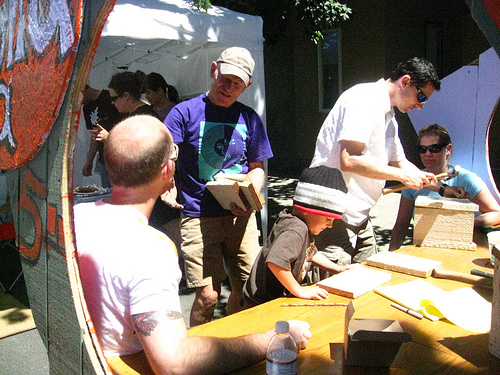

In [15]:
from PIL import Image

Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/2667242810.jpg').show()

In [16]:
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/2667242810.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

NameError: name 'get_sentence_data' is not defined

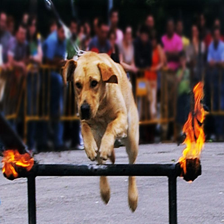

In [28]:
imID = 2229177914
Image.open(f'/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/{imID}.jpg').resize((224,224)).show()

In [ ]:
id_entitiey = load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/2229177914.txt')
id_entitiey

{'35465': ['A light brown dog',
  'A tan dog',
  'A brown dog',
  'A brown dog',
  'A yellow dog'],
 '35467': ['a hurdle', 'a hurdle', 'a pole', 'hurdle'],
 '0': ['that', 'that'],
 '35466': ['fire', 'fire', 'fire', 'a flaming hurdle'],
 '35468': ['each end', 'the ends', 'the ends', 'each end'],
 '35469': ['flames']}

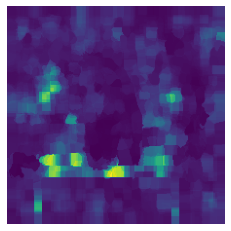

In [29]:
show_heatmap(imID, 'a pole')

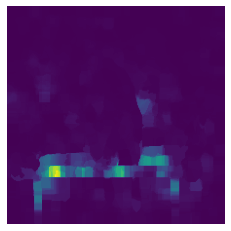

In [30]:
show_heatmap(imID, 'a hurdle')

In [ ]:
show_heatmap(2667242810, 'a white shirt')

In [ ]:
show_heatmap(2667242810, 'a purple shirt')

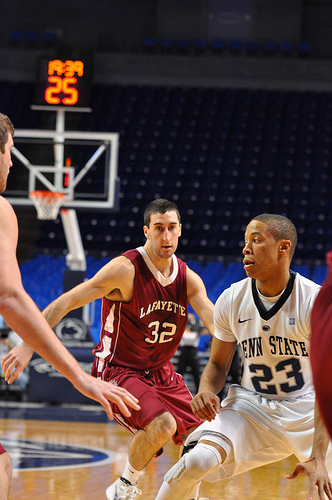

In [ ]:
Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/6474645169.jpg').show()

In [ ]:
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/6474645169.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['A basketball player from Penn State dribbles a ball while being surrounded by Lafayette players .',
 'A basketball game showing Lafayette player number 32 and Penn State player number 23 .',
 'A basketball player in white squats while a player in red moves toward him .',
 'Men from Lafayette and Penn State are playing basketball .',
 'The two college basketball teams are playing a game .']

In [ ]:
id_entitiey = load_entity(f'{Flickr30K_BASE}flickr30k_entities/Sentences/6474645169.txt')
id_entitiey

{'254692': ['A basketball player',
  'Penn State dribbles',
  'Penn State player number 23',
  'A basketball player'],
 '254702': ['a ball'],
 '254693': ['Lafayette players', 'Lafayette'],
 '254691': ['A basketball game', 'basketball', 'a game'],
 '254694': ['Lafayette player number'],
 '254696': ['32'],
 '254704': ['white squats'],
 '254703': ['a player'],
 '254695': ['red moves'],
 '0': ['him'],
 '254697': ['Men'],
 '254698': ['Penn State'],
 '254701': ['The two college basketball teams']}

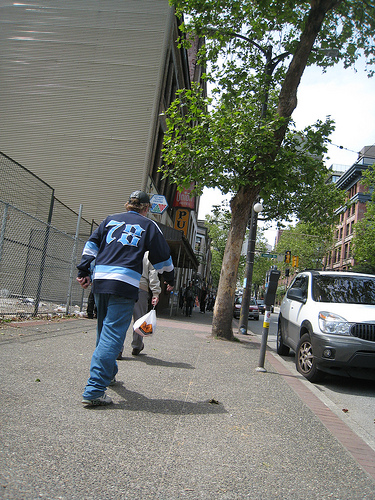

In [ ]:
Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/4684005479.jpg').show()


In [ ]:
# , 'blue shirt'
show_heatmap(4684005479, 'a blue number')

In [ ]:
show_heatmap(4684005479, 'blue shirt')

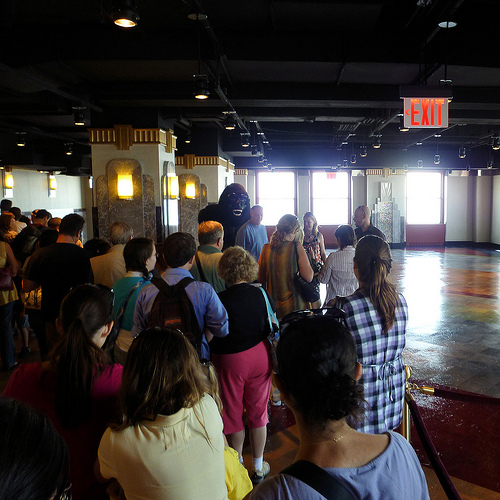

In [ ]:
# 4944644486
Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/4944644486.jpg').show()


In [ ]:
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/4944644486.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['A crowd of people looking towards a person in a gorilla costume inside a building .',
 'A group of people travel through a line along side a gorilla statue .',
 'A crowd waits to interact with some people in an indoor location .',
 'There is a group of people looking at a life sized gorilla .',
 'A group of people are lined up inside waiting .']

In [ ]:
show_heatmap(4944644486, 'some people')

In [ ]:
show_heatmap(4944644486, 'A group of people')

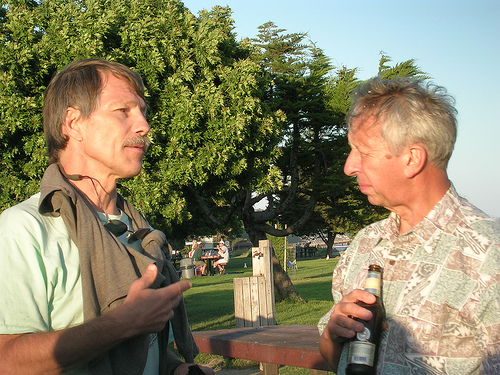

In [ ]:
# 208025491
Image.open('/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/208025491.jpg').show()

In [ ]:
sentenced_data = get_sentence_data(f'{Flickr30K_BASE}flickr30k_entities/Sentences/208025491.txt')
captions = [x['sentence'] for x in sentenced_data]
captions

['A man with a beer and another man facing each other , talking .',
 'Two men having a conversation in an outdoor public area .',
 'One older man holding a beer standing with another man .',
 'Two men , one enjoying a beer , have a discussion .',
 'Two older men are having a conversation at a park .']

In [ ]:
show_heatmap(208025491, 'another man')

In [ ]:
show_heatmap(208025491, 'One older man')

# Failed

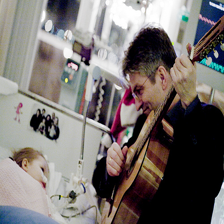

In [23]:
imID =3134644844
Image.open(f'/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/{imID}.jpg').resize((224,224)).show()

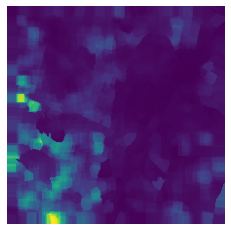

In [25]:
show_heatmap(imID, 'a sick child')

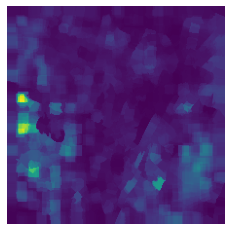

In [27]:
show_heatmap(imID, 'a girl')

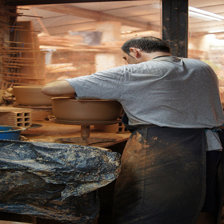

In [31]:
imID = 6232601127
Image.open(f'/work/adapting-CLIP-VGPs/data/flickr/flickr30k_images/{imID}.jpg').resize((224,224)).show()

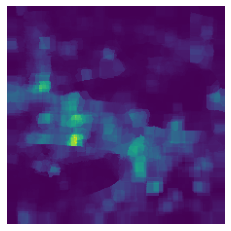

In [33]:
show_heatmap(imID, 'The skilled potter')

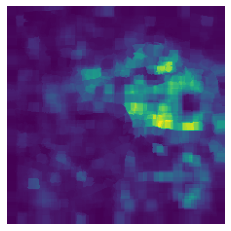

In [34]:
show_heatmap(imID, 'A man')